# Imports and Setup

In [1]:
import numpy as np

import pandas as pd

import healpy as hp
from healpy.newvisufunc import projview

from astrotools import healpytools as hpt

from matplotlib import pyplot as plt, ticker as mticker
import matplotlib.colors as colors

import copy

import os
import sys

In [2]:
#The module that needs to be tested

#Necessary for relative imports (see https://stackoverflow.com/questions/34478398/import-local-function-from-a-module-housed-in-another-directory-with-relative-im)
module_path = os.path.abspath(os.path.join('../../'))           # '../../' is needed because the parent directory is two directories upstream of this test directory
if module_path not in sys.path:
    sys.path.append(module_path)

from kNN_ASMR import HelperFunctions as hf
from kNN_ASMR import HelperFunctions_2DA as hf_2DA
from kNN_ASMR import kNN_2D_Ang

In [3]:
plt.rcParams['font.family'] = 'serif'
plt.rc('text', usetex=True)
plt.rcParams.update({'font.size': 18})
plt.rcParams["axes.linewidth"] = 2*0.8
plt.rcParams["xtick.major.width"] = 2*0.8
plt.rcParams["ytick.major.width"] = 2*0.8
plt.rcParams["xtick.major.size"] = 1.5*3.5
plt.rcParams["ytick.major.size"] = 1.5*3.5
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams["xtick.minor.width"] = 2*0.6
plt.rcParams["ytick.minor.width"] = 2*0.6
plt.rcParams["xtick.minor.size"] = 1.5*2
plt.rcParams["ytick.minor.size"] = 1.5*2
prop_cycle = plt.rcParams['axes.prop_cycle']
DefaultColorCycle = prop_cycle.by_key()['color']
BrightColors = ['cyan', 'yellow', 'lime', '#E0B0FF']

# Function Definitions

In [4]:
def cat2hpx(lon, lat, nside, radec=True):
    '''
    Convert a catalogue to a HEALPix map of number counts per resolution
    element.

    Parameters
    ----------
    lon, lat : (ndarray, ndarray)
        Coordinates of the sources in degree. If radec=True, assume input is in the icrs
        coordinate system. Otherwise assume input is glon, glat

    nside : int
        HEALPix nside of the target map

    radec : bool
        Switch between R.A./Dec and glon/glat as input coordinate system.

    Returns
    -------
    hpx_map : ndarray
        HEALPix map of the catalogue number counts in Galactic coordinates
    '''

    npix = hp.nside2npix(nside)

    if radec:
        eq = SkyCoord(lon, lat, frame='icrs', unit='deg')
        l, b = eq.galactic.l.value, eq.galactic.b.value
    else:
        l, b = lon, lat

    # conver to theta, phi
    theta = np.radians(90. - b)
    phi = np.radians(l)

    # convert to HEALPix indices
    indices = hp.ang2pix(nside, theta, phi)

    idx, counts = np.unique(indices, return_counts=True)

    # fill the fullsky map
    hpx_map = np.zeros(npix, dtype=int)
    hpx_map[idx] = counts

    return hpx_map

In [5]:
def cartesian_corner_to_angles_centre(x, y, z, boxsize, r_max):

    new_x, new_y, new_z = x - boxsize/2, y - boxsize/2, z - boxsize/2
    r = np.sqrt(new_x**2+new_y**2+new_z**2)
    ind = np.where(r<=r_max)
    ang_pos = np.zeros((len(ind[0]), 2))
    ang_pos[:, 0] = np.arcsin(new_z[ind]/r[ind])
    ang_pos[:, 1] = np.arctan2(new_y[ind], new_x[ind])+np.pi
    
    return ang_pos

In [6]:
def PoissonUniformCDFs(a, n, kNN):

    mean=n*a
    sum=0
    for i in range(kNN):
        sum+=(mean**i/np.math.factorial(i))*np.exp(-1*mean)

    return 1-sum

# Main

## Generating and saving datasets

In [40]:
fol_save = '/home/kaustubh/Projects/kNN-Samrajya/Datasets/kNN_2D_Ang'

### Unmasked data

#### Continuous field

In [83]:
# NSIDE = 512
# fol = f'/media/kaustubh/Windows/Downloads_data/Thesis_spare_data/Forecasts/Galaxy_density_fields/LSST_y1/Downgraded_maps/NSIDE_{NSIDE}'

# delta_gal = hp.read_map(f'{fol}/downgraded_density_combined_bins.npy')
# mask = np.ones_like(delta_gal)
# mask[mask!=1] = hp.UNSEEN
# delta_gal_masked = copy.deepcopy(delta_gal)
# delta_gal_masked[mask!=1]=hp.UNSEEN

# delta_gal_sampling = copy.deepcopy(delta_gal)

In [84]:
# fig = plt.figure(figsize=(18, 7))
# ax1, ax2 = plt.subplot(1, 2, 1), plt.subplot(1, 2, 2)

# plt.axes(ax1)
# projview(
#     mask,
#     coord=["C"],
#     graticule=True,
#     graticule_labels=True,
#     unit="\nPoints/pixel",
#     xlabel="longitude",
#     ylabel="latitude",
#     cbar=True,
#     cb_orientation="horizontal",
#     latitude_grid_spacing=45,
#     projection_type="mollweide",
#     title=f"Mask (NSIDE = {NSIDE})",
#     norm="linear", 
#     flip="astro",
#     min=0,
#     max=1,
#     hold=True,
#     sub=121
# )

# plt.axes(ax2)
# projview(
#     1.+delta_gal_masked,
#     coord=["C"],
#     graticule=True,
#     graticule_labels=True,
#     unit=r'$1+\delta$',
#     xlabel="longitude",
#     ylabel="latitude",
#     cbar=True,
#     cb_orientation="horizontal",
#     latitude_grid_spacing=30,
#     projection_type="mollweide",
#     title=f"Galaxy overdensity, unsmoothed (NSIDE = {NSIDE})",
#     norm="log", 
#     flip="astro",
#     min=1+delta_gal_masked[(delta_gal_masked!=hp.UNSEEN)&(delta_gal_masked!=-1)].min(),
#     max=1+delta_gal_masked[delta_gal_masked!=hp.UNSEEN].max(),
#     hold=True,
#     sub=122
# )

# plt.show()
# plt.close()

In [85]:
# #Saving

# np.save(f'{fol_save}/LSST_y1_forecast_Agora_lightcone_galaxy_overdensity_field_NSIDE_{NSIDE}_unmasked.npy', delta_gal_masked)

#### Discrete tracers: Randoms sampled uniformly on the sky, and data points sampled from forecast LSST Y1 Agora Lightcone

In [86]:
# N_realisations = int(1e1)
# N_obj = int(2.8e4)
# Nobj = int(N_obj*12*NSIDE**2/len(np.where(mask==1)[0]))

# r1_pos_arr = np.zeros((N_realisations, Nobj, 2))
# r1_pos_masked_ds_arr = np.zeros((N_realisations, N_obj, 2))

# #Randoms
# for i, r1_pos in enumerate(r1_pos_arr):

#     r1_pos[:, 0] = np.arcsin(np.random.uniform(low=-1, high=1, size=r1_pos.shape[0]))
#     r1_pos[:, 1] = np.random.uniform(low=0, high=2*np.pi, size=r1_pos.shape[0])
#     ipix = hp.ang2pix(NSIDE, np.rad2deg(r1_pos[:, 1]), np.rad2deg(r1_pos[:, 0]), nest=False, lonlat=True)
#     mask_val = mask[ipix]
#     ind_masked = np.where(mask_val!=hp.UNSEEN)[0]
#     r1_pos_masked = r1_pos[ind_masked]
#     r1_pos_masked_ds_arr[i] = r1_pos_masked[np.random.choice(len(r1_pos_masked), N_obj, replace=False)]

# map_1 = cat2hpx(np.rad2deg(r1_pos_masked_ds_arr)[:, :, 1], np.rad2deg(r1_pos_masked_ds_arr)[:, :, 0], nside=64, radec=False).astype(float)

# #Data
# bbh_pos_arr = np.zeros((N_realisations, Nobj, 2))
# bbh_pos_masked_ds_arr = np.zeros((N_realisations, N_obj, 2))

# for i, bbh_pos in enumerate(bbh_pos_arr):

#     sampled_pix = hpt.rand_pix_from_map(1+delta_gal_sampling, n=Nobj)
#     sampled_RAs, sampled_Decs = hp.pix2ang(NSIDE, sampled_pix, lonlat=True)
#     bbh_pos[:, 0] = np.deg2rad(sampled_Decs)
#     bbh_pos[:, 1] = np.deg2rad(sampled_RAs)
#     ipix = hp.ang2pix(NSIDE, np.rad2deg(bbh_pos[:, 1]), np.rad2deg(bbh_pos[:, 0]), nest=False, lonlat=True)
#     mask_val = mask[ipix]
#     ind_masked = np.where(mask_val!=hp.UNSEEN)[0]
#     bbh_pos_masked = bbh_pos[ind_masked]
#     bbh_pos_masked_ds_arr[i] = bbh_pos_masked[np.random.choice(len(bbh_pos_masked), N_obj, replace=False)]

# map_bbh = cat2hpx(np.rad2deg(bbh_pos_masked_ds_arr)[:, :, 1], np.rad2deg(bbh_pos_masked_ds_arr)[:, :, 0], nside=64, radec=False).astype(float)

In [87]:
# projview(
#     1+delta_gal_masked,
#     coord=["C"],
#     graticule=True,
#     graticule_labels=True,
#     unit=r'$1+\delta$',
#     xlabel="longitude",
#     ylabel="latitude",
#     cbar=True,
#     cb_orientation="horizontal",
#     latitude_grid_spacing=30,
#     projection_type="mollweide",
#     title=f"Galaxy overdensity, unsmoothed (NSIDE = {NSIDE})",
#     norm="log", 
#     flip="astro",
#     min=1+delta_gal_masked[(delta_gal_masked!=hp.UNSEEN)&(1+delta_gal_masked>0)].min(),
#     max=1+delta_gal_masked[delta_gal_masked!=hp.UNSEEN].max()
# )

# plt.show()
# plt.close()

# fig = plt.figure(figsize=(18, 7))
# ax1, ax2 = plt.subplot(1, 2, 1), plt.subplot(1, 2, 2)

# plt.axes(ax1)
# projview(
#     map_bbh,
#     coord=["C"],
#     graticule=True,
#     graticule_labels=True,
#     unit="\nPoints/pixel",
#     xlabel="longitude",
#     ylabel="latitude",
#     cbar=True,
#     cb_orientation="horizontal",
#     latitude_grid_spacing=45,
#     projection_type="mollweide",
#     title=f"{N_realisations} realisations of {N_obj} sampled BBHs (NSIDE={64})",
#     norm="linear", 
#     flip="astro",
#     # min=map_gal[mask!=hp.UNSEEN].min(),
#     # max=map_gal[mask!=hp.UNSEEN].max(),
#     hold=True,
#     sub=121
# )

# plt.axes(ax2)
# projview(
#     map_1,
#     coord=["C"],
#     graticule=True,
#     graticule_labels=True,
#     unit="\nPoints/pixel",
#     xlabel="longitude",
#     ylabel="latitude",
#     cbar=True,
#     cb_orientation="horizontal",
#     latitude_grid_spacing=45,
#     projection_type="mollweide",
#     title=f"{N_realisations} realisations of {N_obj} Randoms (NSIDE={64})",
#     norm="linear", 
#     flip="astro",
#     # min=map_1[mask!=hp.UNSEEN].min(),
#     # max=map_1[mask!=hp.UNSEEN].max(),
#     hold=True,
#     sub=122
# )

# plt.show()
# plt.close()

In [88]:
# #Saving

# np.save(f'{fol_save}/Discrete_tracer_catalog_{r1_pos_masked_ds_arr.shape[0]}_realisations_of_{r1_pos_masked_ds_arr.shape[1]}_galaxies_randomly_sampled_from_the_sky.npy', r1_pos_masked_ds_arr)
# np.save(f'{fol_save}/Discrete_tracer_catalog_{bbh_pos_masked_ds_arr.shape[0]}_realisations_of_{bbh_pos_masked_ds_arr.shape[1]}_galaxies_sampled_from_LSST_y1_forecast_Agora_lightcone_galaxy_overdensity_field_NSIDE_{NSIDE}_unmasked.npy', bbh_pos_masked_ds_arr)

#### Discrete tracers: Randoms sampled uniformly on the sky, data points generated by projecting cluster-sizes and galaxy-sizes haloes from one of the Quijote simulation high-resolution boxes onto the sky as observed by a viewer at the centre of the box

In [33]:
folder_cl = '/media/kaustubh/Downloads/Projects_data/Secondary_bias_project/Simulations/Cluster_cat'
folder_ga = '/media/kaustubh/Downloads/Projects_data/Secondary_bias_project/Simulations/Galaxy_cat'

In [35]:
sim_num = 49
boxsize=1000.

#Converting the simulation number into a simulation name string. 
#For example, when sim_num is 5, name will be 'sim_005' and when sim_num is 50, name will be 'sim_050'
num = str(sim_num).zfill(3)

#Reading in the halo catalogs corresponding to the given simulation number   
filepath_cl = '{a}/sim_{b}'.format(a = folder_cl, b = num)
filepath_ga = '{a}/sim_{b}'.format(a = folder_ga, b = num)
cl_data_selected = pd.read_csv(filepath_cl)
ga_data_selected = pd.read_csv(filepath_ga)

#Positions of halos

all_cl_pos = np.zeros((len(cl_data_selected), 3), dtype = np.float32)
all_cl_pos[:, 0] = cl_data_selected.loc[:, '8'].values
all_cl_pos[:, 1] = cl_data_selected.loc[:, '9'].values
all_cl_pos[:, 2] = cl_data_selected.loc[:, '10'].values

all_ga_pos = np.zeros((len(ga_data_selected), 3), dtype = np.float32)
all_ga_pos[:, 0] = ga_data_selected.loc[:, '8'].values
all_ga_pos[:, 1] = ga_data_selected.loc[:, '9'].values
all_ga_pos[:, 2] = ga_data_selected.loc[:, '10'].values

print(all_cl_pos.shape, all_ga_pos.shape)

#Converting 3D positions to sky angles, observer at centre of box
all_cl_angpos = cartesian_corner_to_angles_centre(all_cl_pos[:, 0], all_cl_pos[:, 1], all_cl_pos[:, 2], boxsize, boxsize/2)
all_ga_angpos = cartesian_corner_to_angles_centre(all_ga_pos[:, 0], all_ga_pos[:, 1], all_ga_pos[:, 2], boxsize, boxsize/2)
print(all_cl_angpos.shape, all_ga_angpos.shape)

(9729, 3) (687918, 3)
(5128, 2) (361793, 2)


In [36]:
NSIDE = 256
mask = np.ones(12*NSIDE**2).astype('float')
mask[mask!=1] = hp.UNSEEN

In [37]:
N_realisations = int(1e1)
N_obj = int(2e3)
Nobj = int(N_obj*12*NSIDE**2/len(np.where(mask==1)[0]))

#Randoms
r1_pos_arr = np.zeros((N_realisations, Nobj, 2))
r1_pos_masked_ds_arr = np.zeros((N_realisations, N_obj, 2))

for i, r1_pos in enumerate(r1_pos_arr):

    r1_pos[:, 0] = np.arcsin(np.random.uniform(low=-1, high=1, size=r1_pos.shape[0]))
    r1_pos[:, 1] = np.random.uniform(low=0, high=2*np.pi, size=r1_pos.shape[0])
    ipix = hp.ang2pix(NSIDE, np.rad2deg(r1_pos[:, 1]), np.rad2deg(r1_pos[:, 0]), nest=False, lonlat=True)
    mask_val = mask[ipix]
    ind_masked = np.where(mask_val!=hp.UNSEEN)[0]
    r1_pos_masked = r1_pos[ind_masked]
    r1_pos_masked_ds_arr[i] = r1_pos_masked[np.random.choice(len(r1_pos_masked), N_obj, replace=False)]

map_1 = cat2hpx(np.rad2deg(r1_pos_masked_ds_arr)[:, :, 1], np.rad2deg(r1_pos_masked_ds_arr)[:, :, 0], nside=64, radec=False).astype(float)

#Cluster-sized haloes: 10 bootstrap realisations
cl_pos_arr = np.zeros((N_realisations, Nobj, 2))
cl_pos_masked_ds_arr = np.zeros((N_realisations, N_obj, 2))
for i, cl_pos in enumerate(cl_pos_arr):

    sel_ind = np.random.choice(len(all_cl_angpos), N_obj, replace=False)
    cl_pos = all_cl_angpos[sel_ind]
    ipix = hp.ang2pix(NSIDE, np.rad2deg(cl_pos[:, 1]), np.rad2deg(cl_pos[:, 0]), nest=False, lonlat=True)
    mask_val = mask[ipix]
    ind_masked = np.where(mask_val!=hp.UNSEEN)[0]
    cl_pos_masked = cl_pos[ind_masked]
    cl_pos_masked_ds_arr[i] = cl_pos_masked[np.random.choice(len(cl_pos_masked), N_obj, replace=False)]

map_cl = cat2hpx(np.rad2deg(cl_pos_masked_ds_arr)[:, :, 1], np.rad2deg(cl_pos_masked_ds_arr)[:, :, 0], nside=64, radec=False).astype(float)

#Galaxy-sized haloes: single realisation
ga_pos = np.zeros((Nobj, 2))
ga_pos_masked_ds = np.zeros((N_obj, 2))
sel_ind = np.random.choice(len(all_ga_angpos), N_obj, replace=False)
ga_pos = all_ga_angpos[sel_ind]
ipix = hp.ang2pix(NSIDE, np.rad2deg(ga_pos[:, 1]), np.rad2deg(ga_pos[:, 0]), nest=False, lonlat=True)
mask_val = mask[ipix]
ind_masked = np.where(mask_val!=hp.UNSEEN)[0]
ga_pos_masked = ga_pos[ind_masked]
ga_pos_masked_ds = ga_pos_masked[np.random.choice(len(ga_pos_masked), N_obj, replace=False)]

map_ga = cat2hpx(np.rad2deg(ga_pos_masked_ds)[:, 1], np.rad2deg(ga_pos_masked_ds)[:, 0], nside=64, radec=False).astype(float)

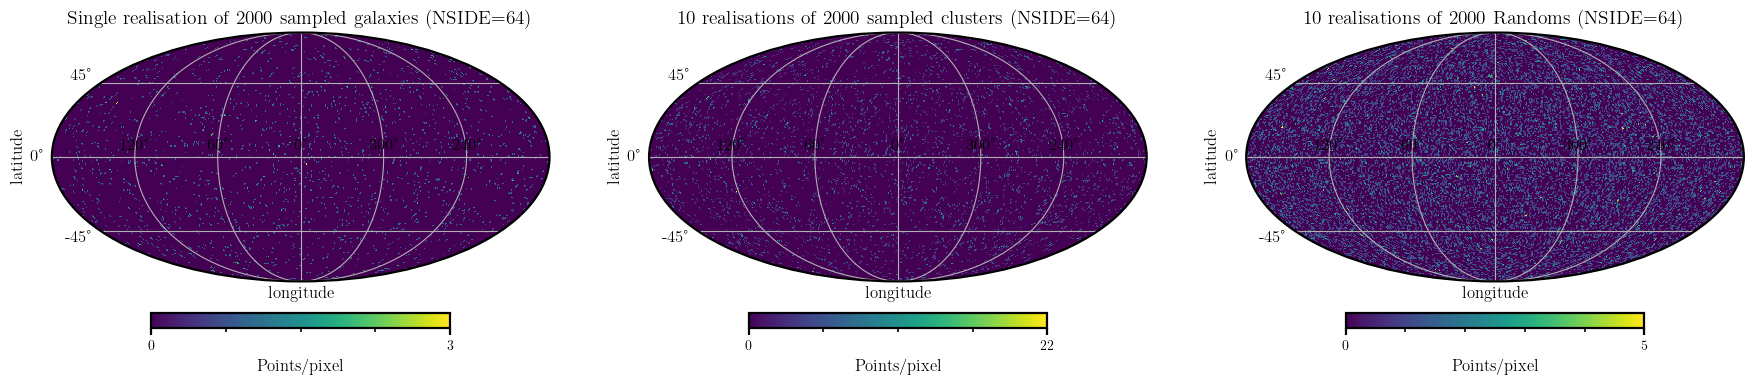

In [38]:
fig = plt.figure(figsize=(18, 7))
ax1, ax2, ax3 = plt.subplot(1, 3, 1), plt.subplot(1, 3, 2), plt.subplot(1, 3, 3)

plt.axes(ax1)
projview(
    map_ga,
    coord=["C"],
    graticule=True,
    graticule_labels=True,
    unit="\nPoints/pixel",
    xlabel="longitude",
    ylabel="latitude",
    cbar=True,
    cb_orientation="horizontal",
    latitude_grid_spacing=45,
    projection_type="mollweide",
    title=f"Single realisation of {N_obj} sampled galaxies (NSIDE={64})",
    norm="linear", 
    flip="astro",
    # min=map_gal[mask!=hp.UNSEEN].min(),
    # max=map_gal[mask!=hp.UNSEEN].max(),
    hold=True,
    sub=131
)

plt.axes(ax2)
projview(
    map_cl,
    coord=["C"],
    graticule=True,
    graticule_labels=True,
    unit="\nPoints/pixel",
    xlabel="longitude",
    ylabel="latitude",
    cbar=True,
    cb_orientation="horizontal",
    latitude_grid_spacing=45,
    projection_type="mollweide",
    title=f"{N_realisations} realisations of {N_obj} sampled clusters (NSIDE={64})",
    norm="linear", 
    flip="astro",
    # min=map_gal[mask!=hp.UNSEEN].min(),
    # max=map_gal[mask!=hp.UNSEEN].max(),
    hold=True,
    sub=132
)

plt.axes(ax3)
projview(
    map_1,
    coord=["C"],
    graticule=True,
    graticule_labels=True,
    unit="\nPoints/pixel",
    xlabel="longitude",
    ylabel="latitude",
    cbar=True,
    cb_orientation="horizontal",
    latitude_grid_spacing=45,
    projection_type="mollweide",
    title=f"{N_realisations} realisations of {N_obj} Randoms (NSIDE={64})",
    norm="linear", 
    flip="astro",
    # min=map_1[mask!=hp.UNSEEN].min(),
    # max=map_1[mask!=hp.UNSEEN].max(),
    hold=True,
    sub=133
)

plt.show()
plt.close()

In [41]:
#Saving

np.save(f'{fol_save}/Discrete_tracer_catalog_{r1_pos_masked_ds_arr.shape[0]}_realisations_of_{r1_pos_masked_ds_arr.shape[1]}_objects_randomly_sampled_from_the_sky.npy', r1_pos_masked_ds_arr)
np.save(f'{fol_save}/Discrete_tracer_catalog_{cl_pos_masked_ds_arr.shape[0]}_realisations_of_{cl_pos_masked_ds_arr.shape[1]}_cluster_sized_haloes_projected_from_quijote_high_res_box_realisation_{sim_num}_unmasked.npy', cl_pos_masked_ds_arr)
np.save(f'{fol_save}/Discrete_tracer_catalog_single_realisation_of_{ga_pos_masked_ds.shape[0]}_galaxy_sized_haloes_projected_from_quijote_high_res_box_realisation_{sim_num}_unmasked.npy', ga_pos_masked_ds)

## Tests for Tracer-field correlations, unmasked data

### Loading datasets

In [ ]:
fol_dataset = '/home/kaustubh/Projects/kNN-Samrajya/Datasets/kNN_2D_Ang'
NSIDE = 512
n_reals = 10
n_tracer = 28000
mask = np.ones(12*NSIDE**2)
mask[mask!=1] = hp.UNSEEN
delta_gal_masked = np.load(f'{fol_dataset}/LSST_y1_forecast_Agora_lightcone_galaxy_overdensity_field_NSIDE_{NSIDE}_unmasked.npy')
bbh_pos_masked_ds_arr = np.load(f'{fol_dataset}/Discrete_tracer_catalog_{n_reals}_realisations_of_{n_tracer}_galaxies_sampled_from_LSST_y1_forecast_Agora_lightcone_galaxy_overdensity_field_NSIDE_{NSIDE}_unmasked.npy')
r1_pos_masked_ds_arr = np.load(f'{fol_dataset}/Discrete_tracer_catalog_{n_reals}_realisations_of_{n_tracer}_galaxies_randomly_sampled_from_the_sky.npy')

### Query mask and query positions

In [7]:
query_mask, query_pos = hf_2DA.create_query_2DA(NSIDE, mask, tolerance=0)

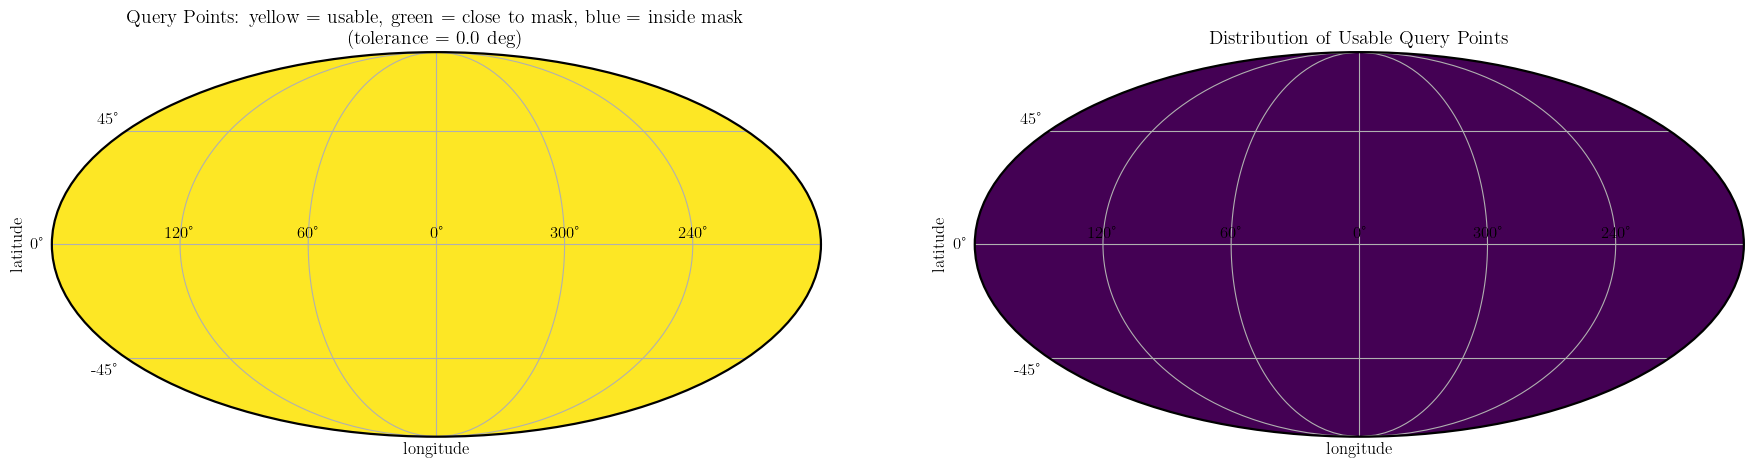

In [8]:
fig = plt.figure(figsize=(18, 7))
ax1, ax2 = plt.subplot(1, 2, 1), plt.subplot(1, 2, 2)

plt.axes(ax1)
projview(
    query_mask,
    coord=["C"],
    graticule=True,
    graticule_labels=True,
    unit="\nPoints/pixel",
    xlabel="longitude",
    ylabel="latitude",
    cbar=False,
    cb_orientation="horizontal",
    latitude_grid_spacing=45,
    projection_type="mollweide",
    title=f"Query Points: yellow = usable, green = close to mask, blue = inside mask \n(tolerance = {np.rad2deg(np.deg2rad(0))} deg)",
    norm="linear", 
    flip="astro",
    min = 0,
    max = 2,
    hold=True,
    sub=121
)

hpx_querymap = cat2hpx(np.rad2deg(query_pos)[:, 1], np.rad2deg(query_pos)[:, 0], nside=NSIDE, radec=False)
plt.axes(ax2)
projview(
    hpx_querymap,
    coord=["C"],
    graticule=True,
    graticule_labels=True,
    unit="\nPoints/pixel",
    xlabel="longitude",
    ylabel="latitude",
    cbar=False,
    cb_orientation="horizontal",
    latitude_grid_spacing=45,
    projection_type="mollweide",
    title="Distribution of Usable Query Points",
    norm="linear", 
    flip="astro",
    hold=True,
    sub=122
)

plt.show()
plt.close()

### Determining the bins

/tmp/ipykernel_17315/2913211282.py:6: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sum+=(mean**i/np.math.factorial(i))*np.exp(-1*mean)


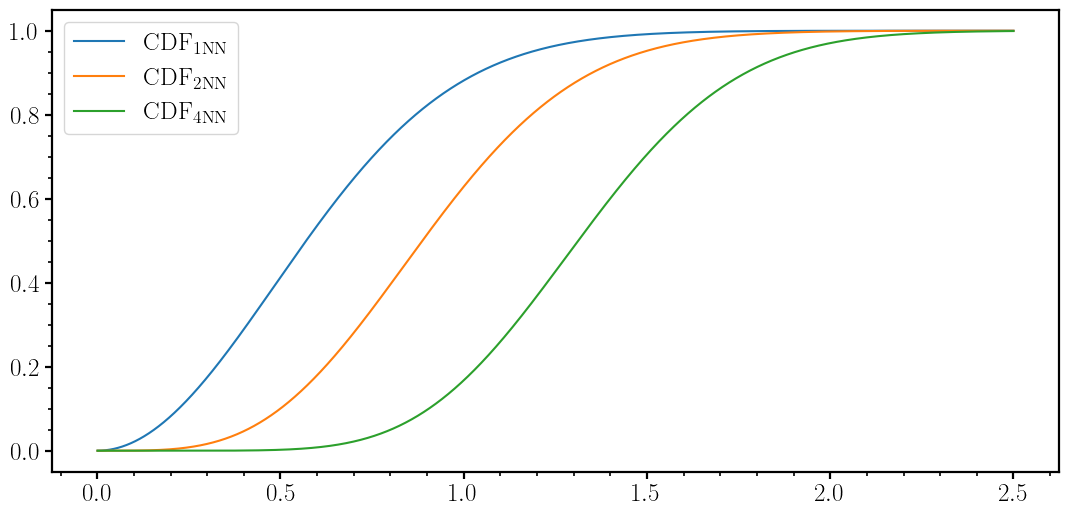

1NN 0.16 1.19
2NN 0.41 1.49
4NN 0.80 1.91

Angular distance bins for 1NN-CDF: 

 [0.14743297 0.18687831 0.23687717 0.30025309 0.3805851  0.48240975
 0.61147734 0.77507666 0.98244659 1.24529785]

Number of bins for 1NN-CDF:  10

Angular distance bins for 2NN-CDF: 

 [0.38811625 0.4531917  0.52917833 0.61790565 0.72150987 0.84248541
 0.98374492 1.1486894  1.34129012 1.5661842 ]

Number of bins for 2NN-CDF:  10

Angular distance bins for 4NN-CDF: 

 [0.76070084 0.84706703 0.94323881 1.05032944 1.16957862 1.30236676
 1.450231   1.614883   1.79822878 2.00239073]

Number of bins for 4NN-CDF:  10


In [9]:
k_List = [1, 2, 4]
n_bar_red = (bbh_pos_masked_ds_arr.shape[1]/(4*np.pi))*(12*NSIDE**2/len(np.where(mask!=hp.UNSEEN)[0]))

bins = np.zeros((len(k_List), 10000))
for i, k in enumerate(k_List):
    bins[i] = np.deg2rad(np.geomspace(0.001, 2.5, 10000))

Theoretical_Uniform_CDFs_test = []
for i, k in enumerate(k_List):
    Theoretical_Uniform_CDFs_test.append(PoissonUniformCDFs(2*np.pi*(1-np.cos(bins[i])), n_bar_red, k))

plt.figure(figsize=(13,6))
for i, k in enumerate(k_List):
    plt.plot(np.rad2deg(bins[i]), Theoretical_Uniform_CDFs_test[i], label='CDF$_{{\\rm {}NN}}$'.format(k))
plt.legend()
plt.show()
plt.close()

low_bin = np.zeros(len(k_List)).astype(int)
high_bin = np.zeros(len(k_List)).astype(int)
for i, k in enumerate(k_List):
    low_bin[i] = np.searchsorted(Theoretical_Uniform_CDFs_test[i], 0.05)
    high_bin[i] = np.searchsorted(Theoretical_Uniform_CDFs_test[i], 0.95)
    print(f'{k}NN', '{:.2f}'.format(np.rad2deg(bins[i][low_bin[i]])), '{:.2f}'.format(np.rad2deg(bins[i][high_bin[i]])))

sel_bins = np.zeros((len(k_List), 10))
for i, k in enumerate(k_List):
    sel_bins[i] = np.geomspace(bins[i][low_bin[i]]*0.95, bins[i][high_bin[i]]*1.05, 10)

for i, k in enumerate(k_List):
    print(f'\nAngular distance bins for {k}NN-CDF: \n\n', np.rad2deg(sel_bins[i]))
    print(f'\nNumber of bins for {k}NN-CDF: ', len(sel_bins[i]))

### Computing the theoretical CDFs for Poisson data

In [10]:
th_uni_arr = np.zeros((len(k_List), sel_bins.shape[1]))
for i, k in enumerate(k_List):
    th_uni_arr[i] = PoissonUniformCDFs(2*np.pi*(1-np.cos(sel_bins[i])), n_bar_red, k)

# for i, k in enumerate(k_List):
#     plt.plot(np.rad2deg(sel_bins[i]), th_uni_arr[i])

/tmp/ipykernel_17315/2913211282.py:6: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sum+=(mean**i/np.math.factorial(i))*np.exp(-1*mean)


### testing kNN_2D_Ang.TracerAuto2DA

In [12]:
random_kNN_results = kNN_2D_Ang.TracerAuto2DA(k_List, sel_bins, query_pos, r1_pos_masked_ds_arr[0], ReturnNNdist=False, Verbose=True)

Checking inputs ...
	done.

building the tree ...
	done; time taken: 5.16e-02 s.

computing the tracer NN distances ...
	done; time taken: 8.89e+01 s.

computing the tracer auto-CDFs P_{>=k} ...
	done; time taken: 3.31e+00 s.

total time taken: 9.24e+01 s.


In [13]:
random_autoCDFs = random_kNN_results

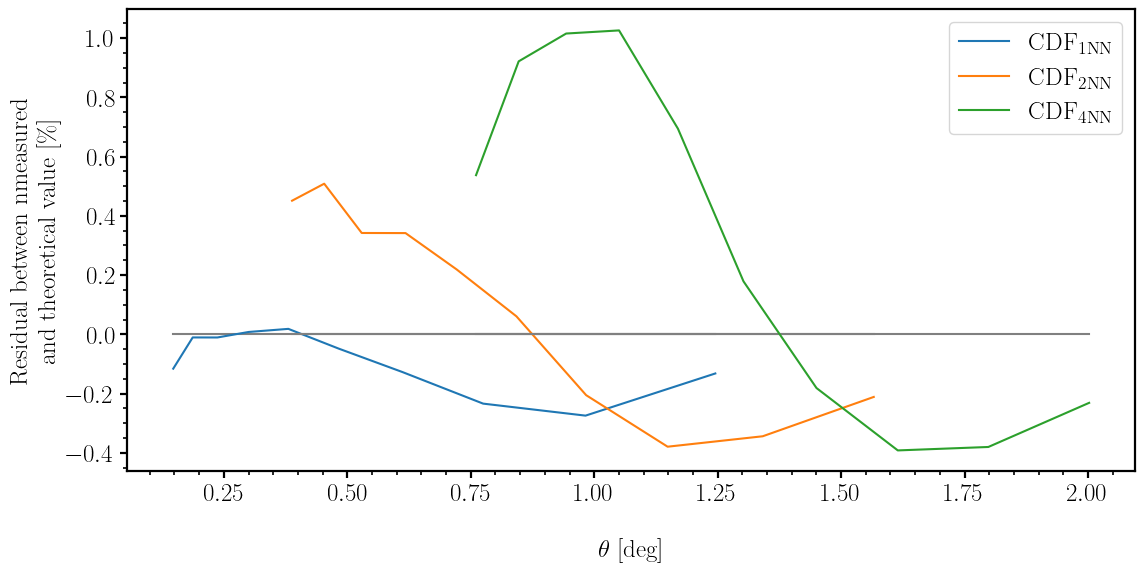

In [81]:
plt.figure(figsize=(13, 6))
for i, k in enumerate(k_List):
    plt.plot(np.rad2deg(sel_bins[i]), 100*(th_uni_arr[i]/th_uni_arr[i] - 1), c='grey', label=None)
    plt.plot(np.rad2deg(sel_bins[i]), 100*(random_autoCDFs[i]/th_uni_arr[i] - 1), c=DefaultColorCycle[i], label='CDF$_{{\\rm {}NN}}$'.format(k))
plt.xlabel('\n$\\theta$ [deg]')
plt.ylabel('Residual between nmeasured \nand theoretical value [\%]')
plt.legend()
plt.show()
plt.close()

### testing kNN_2D_Ang.TracerFieldCross2DA

In [55]:
delta_threshold = 75.0

In [56]:
randomxgalaxy_kNN_results = kNN_2D_Ang.TracerFieldCross2DA(k_List, sel_bins, query_pos, r1_pos_masked_ds_arr[0], delta_gal_masked, query_mask, delta_threshold, ReturnSmoothedDict=False, Verbose=True)

Checking inputs ...
	done.

initiating step 1 (NN measurements for the discrete tracer set)...

	building the tree ...
		done; time taken: 2.85e-02 s.

	computing the tracer NN distances ...
		done; time taken: 5.46e+01 s.

	computing the tracer auto-CDFs P_{>=k} ...
		done; time taken: 1.98e+00 s.

time taken for step 1: 5.66e+01 s.

initiating step 2 (smoothing the continuous field at the given angular distance scales)...
	done; time taken for step 2: 9.76e+01 s.

initiating step 3 (computing the tracer-field cross-correlation)...

	Computing P_(>dt) and P_(>=k, >dt) for k = 1 ...

	Computing P_(>dt) and P_(>=k, >dt) for k = 2 ...

	Computing P_(>dt) and P_(>=k, >dt) for k = 4 ...

	done; time taken for step 3: 1.83e+00 s.

total time taken: 1.56e+02 s.


In [57]:
random_autoCDFs = randomxgalaxy_kNN_results[0]
random_pdt = randomxgalaxy_kNN_results[1]
random_jointCDFs = randomxgalaxy_kNN_results[2]

In [58]:
dataxgalaxy_kNN_results = kNN_2D_Ang.TracerFieldCross2DA(k_List, sel_bins, query_pos, bbh_pos_masked_ds_arr[0], delta_gal_masked, query_mask, delta_threshold, ReturnSmoothedDict=True, Verbose=True)

Checking inputs ...
	done.

initiating step 1 (NN measurements for the discrete tracer set)...

	building the tree ...
		done; time taken: 2.32e-02 s.

	computing the tracer NN distances ...
		done; time taken: 5.36e+01 s.

	computing the tracer auto-CDFs P_{>=k} ...
		done; time taken: 1.83e+00 s.

time taken for step 1: 5.55e+01 s.

initiating step 2 (smoothing the continuous field at the given angular distance scales)...
	done; time taken for step 2: 1.01e+02 s.

initiating step 3 (computing the tracer-field cross-correlation)...

	Computing P_(>dt) and P_(>=k, >dt) for k = 1 ...

	Computing P_(>dt) and P_(>=k, >dt) for k = 2 ...

	Computing P_(>dt) and P_(>=k, >dt) for k = 4 ...

	done; time taken for step 3: 1.89e+00 s.

total time taken: 1.59e+02 s.


In [59]:
data_autoCDFs = dataxgalaxy_kNN_results[0]
data_pdt = dataxgalaxy_kNN_results[1]
data_jointCDFs = dataxgalaxy_kNN_results[2]
smootheddict = dataxgalaxy_kNN_results[3]

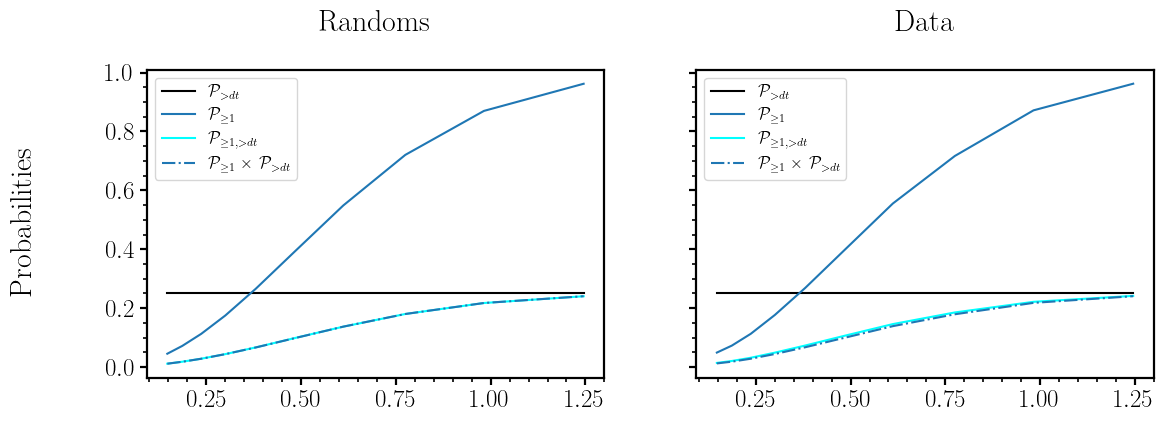

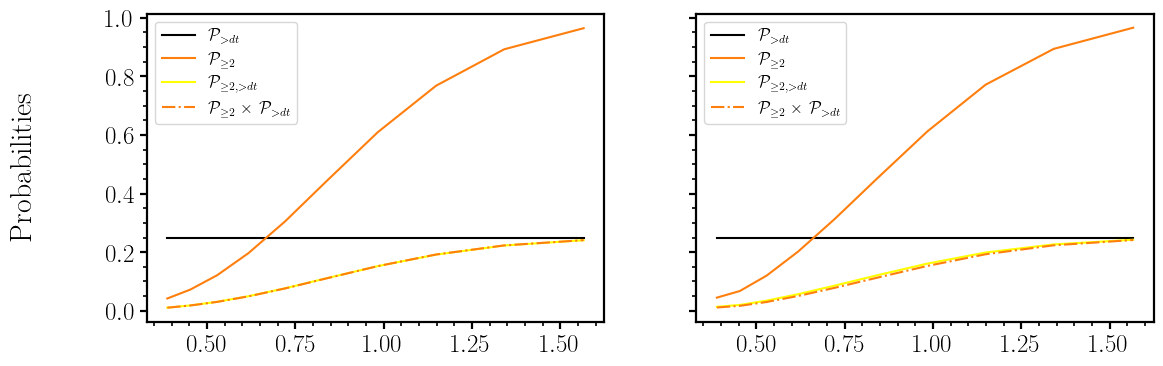

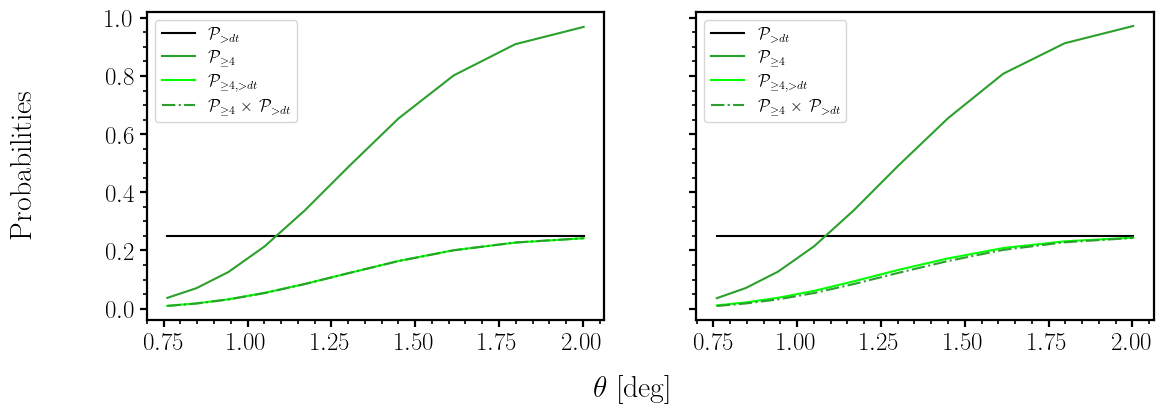

In [71]:
for i, k in enumerate(k_List):

    fig, (ax, ax1) = plt.subplots(1, 2, figsize=(13, 4), sharey=True)
    
    ax.plot(np.rad2deg(sel_bins[i]), random_pdt[i], c='k', label='$\\mathcal{{P}}_{{>dt}}$')
    ax.plot(np.rad2deg(sel_bins[i]), random_autoCDFs[i], c=DefaultColorCycle[i], label='$\\mathcal{{P}}_{{\\geq {:.0f}}}$'.format(k))
    ax.plot(np.rad2deg(sel_bins[i]), random_jointCDFs[i], c=BrightColors[i], label='$\\mathcal{{P}}_{{\\geq {:.0f}, >dt}}$'.format(k))
    ax.plot(np.rad2deg(sel_bins[i]), random_autoCDFs[i]*random_pdt[i], c=DefaultColorCycle[i], ls='-.', label='$\\mathcal{{P}}_{{\\geq {:.0f}}}$ $\\times$ $\\mathcal{{P}}_{{>dt}}$'.format(k))
    ax.legend(fontsize=12)
    if i==0: ax.set_title('Randoms\n')
    
    ax1.plot(np.rad2deg(sel_bins[i]), data_pdt[i], c='k', label='$\\mathcal{{P}}_{{>dt}}$')
    ax1.plot(np.rad2deg(sel_bins[i]), data_autoCDFs[i], c=DefaultColorCycle[i], label='$\\mathcal{{P}}_{{\\geq {:.0f}}}$'.format(k))
    ax1.plot(np.rad2deg(sel_bins[i]), data_jointCDFs[i], c=BrightColors[i], label='$\\mathcal{{P}}_{{\\geq {:.0f}, >dt}}$'.format(k))
    ax1.plot(np.rad2deg(sel_bins[i]), data_autoCDFs[i]*data_pdt[i], c=DefaultColorCycle[i], ls='-.', label='$\\mathcal{{P}}_{{\\geq {:.0f}}}$ $\\times$ $\\mathcal{{P}}_{{>dt}}$'.format(k))
    ax1.legend(fontsize=12)
    if i==0: ax1.set_title('Data\n')

    if i==len(k_List)-1: fig.supxlabel(r'$\theta$ [deg]', y=-0.1)
    fig.supylabel('Probabilities')
    
    plt.show()
    plt.close()

In [65]:
randoms_psi = hf.kNN_excess_cross_corr(random_autoCDFs, random_pdt, random_jointCDFs, k1_k2_list=None)
data_psi = hf.kNN_excess_cross_corr(data_autoCDFs, data_pdt, data_jointCDFs, k1_k2_list=None)

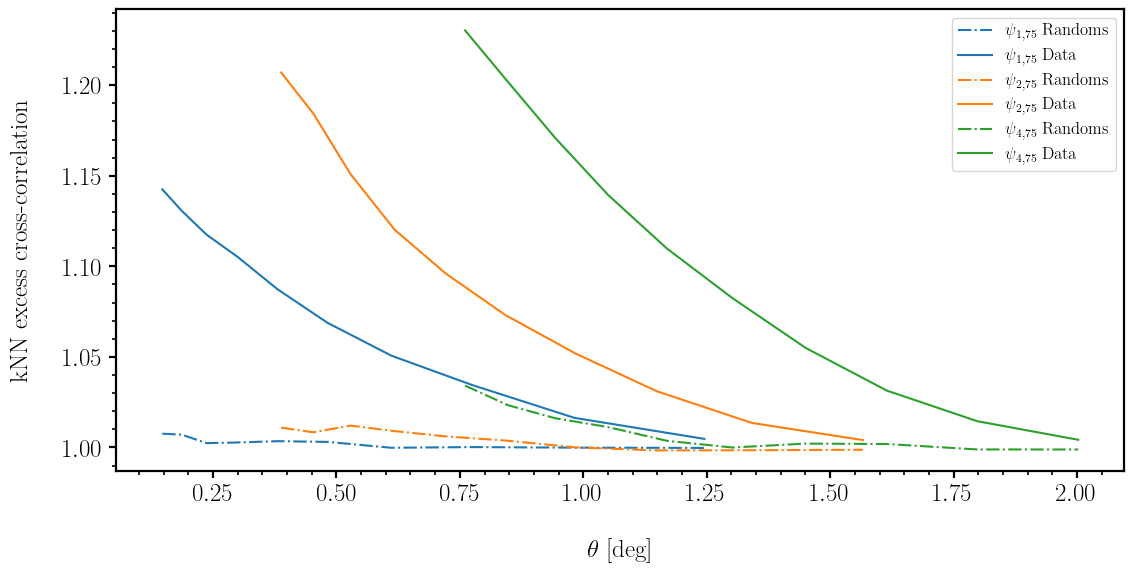

In [66]:
plt.figure(figsize=(13, 6))

for i, k in enumerate(k_List):
    plt.plot(np.rad2deg(sel_bins[i]), randoms_psi[i], c=DefaultColorCycle[i], ls='-.', label='$\\psi_{{{:.0f}, {:.0f}}}$ Randoms'.format(k, delta_threshold))
    plt.plot(np.rad2deg(sel_bins[i]), data_psi[i], c=DefaultColorCycle[i], label='$\\psi_{{{:.0f}, {:.0f}}}$ Data'.format(k, delta_threshold))
        
plt.xlabel('\n$\\theta$ [deg]')
plt.ylabel('kNN excess cross-correlation\n')
plt.legend(fontsize=12)
plt.show()
plt.close()

### testing kNN_2D_Ang.TracerFieldCross2DA_DataVector

In [12]:
delta_threshold = 75.0

In [13]:
combined_pos_masked_ds_arr = np.concatenate([r1_pos_masked_ds_arr, bbh_pos_masked_ds_arr], axis=0)

In [14]:
r1_pos_masked_ds_arr.shape, bbh_pos_masked_ds_arr.shape, combined_pos_masked_ds_arr.shape

((10, 28000, 2), (10, 28000, 2), (20, 28000, 2))

In [30]:
bbhxgalaxy_kNN_results_DataVector = kNN_2D_Ang.TracerFieldCross2DA_DataVector(k_List, sel_bins, query_pos, combined_pos_masked_ds_arr, delta_gal_masked, query_mask, delta_threshold, ReturnSmoothedDict=False, Verbose=True)

Checking inputs ...
	done.

initiating step 1 (smoothing the continuous field at the given angular distance scales)...
	done; time taken for step 1: 1.04e+02 s.

initiating step 2 (looping the tracer-field cross-correlation computations over the multiple tracer realisations)...


--------------  Realisation 1/20  --------------


building the BallTree for the discrete tracer set ...
	done; time taken: 2.58e-02 s.

computing the tracer NN distances ...
	done; time taken: 5.28e+01 s.

computing the tracer auto-CDFs P_{>=k} ...
	done; time taken: 2.14e+00 s.

computing the tracer-field cross-correlation ...

	Computing P_(>dt) and P_(>=k, >dt) for k = 1 ...

	Computing P_(>dt) and P_(>=k, >dt) for k = 2 ...

	Computing P_(>dt) and P_(>=k, >dt) for k = 4 ...
	done; time taken: 1.73e+00 s.

time taken for realisation 1: 5.67e+01 s.


--------------  Realisation 2/20  --------------


building the BallTree for the discrete tracer set ...
	done; time taken: 2.74e-02 s.

computing the tracer N

In [31]:
autoCDFs = bbhxgalaxy_kNN_results_DataVector[0]
pdt = bbhxgalaxy_kNN_results_DataVector[1]
jointCDFs = bbhxgalaxy_kNN_results_DataVector[2]

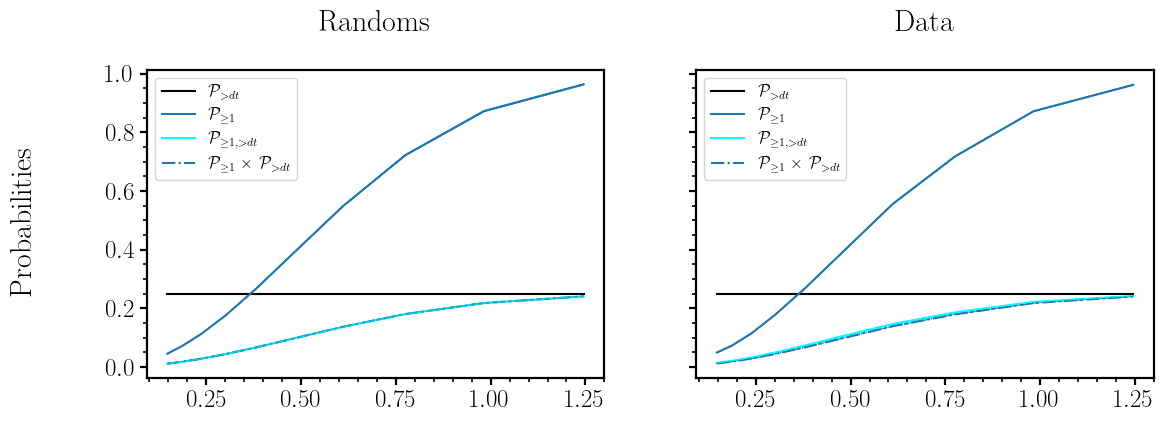

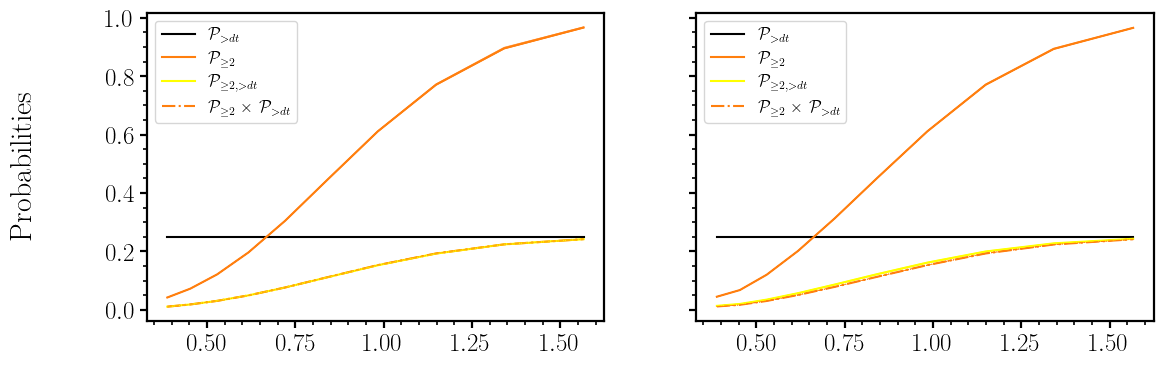

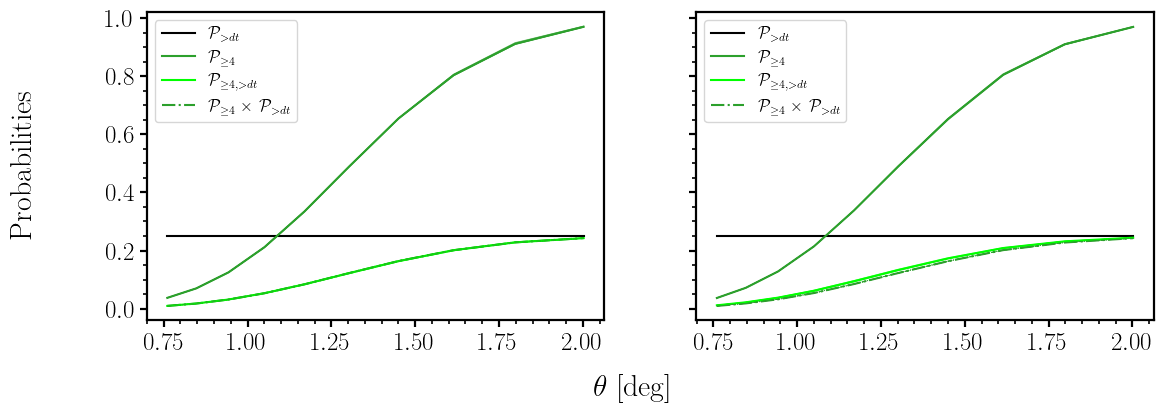

In [70]:
for i, k in enumerate(k_List):

    fig, (ax, ax1) = plt.subplots(1, 2, figsize=(13, 4), sharey=True)
    
    ax.plot(np.rad2deg(sel_bins[i]), pdt[i], c='k', label='$\\mathcal{{P}}_{{>dt}}$')
    ax.plot(np.rad2deg(sel_bins[i]), np.mean(autoCDFs[i][:n_reals], axis=0), c=DefaultColorCycle[i], label='$\\mathcal{{P}}_{{\\geq {:.0f}}}$'.format(k))
    ax.plot(np.rad2deg(sel_bins[i]), np.mean(jointCDFs[i][:n_reals], axis=0), c=BrightColors[i], label='$\\mathcal{{P}}_{{\\geq {:.0f}, >dt}}$'.format(k))
    ax.plot(np.rad2deg(sel_bins[i]), np.mean(autoCDFs[i][:n_reals], axis=0)*pdt[i], c=DefaultColorCycle[i], ls='-.', label='$\\mathcal{{P}}_{{\\geq {:.0f}}}$ $\\times$ $\\mathcal{{P}}_{{>dt}}$'.format(k))
    for realisation in range(n_reals):
        ax.plot(np.rad2deg(sel_bins[i]), autoCDFs[i][:n_reals][realisation], c=DefaultColorCycle[i], lw=0.5, alpha=0.5, label=None)
        ax.plot(np.rad2deg(sel_bins[i]), jointCDFs[i][:n_reals][realisation], c=BrightColors[i], lw=0.5, alpha=0.5, label=None)
        ax.plot(np.rad2deg(sel_bins[i]), autoCDFs[i][:n_reals][realisation]*pdt[i], lw=0.5, alpha=0.5, c=DefaultColorCycle[i], ls='-.', label=None)
    ax.legend(fontsize=12)
    if i==0: ax.set_title('Randoms\n')
    
    ax1.plot(np.rad2deg(sel_bins[i]), pdt[i], c='k', label='$\\mathcal{{P}}_{{>dt}}$')
    ax1.plot(np.rad2deg(sel_bins[i]), np.mean(autoCDFs[i][n_reals:], axis=0), c=DefaultColorCycle[i], label='$\\mathcal{{P}}_{{\\geq {:.0f}}}$'.format(k))
    ax1.plot(np.rad2deg(sel_bins[i]), np.mean(jointCDFs[i][n_reals:], axis=0), c=BrightColors[i], label='$\\mathcal{{P}}_{{\\geq {:.0f}, >dt}}$'.format(k))
    ax1.plot(np.rad2deg(sel_bins[i]), np.mean(autoCDFs[i][n_reals:], axis=0)*pdt[i], c=DefaultColorCycle[i], ls='-.', label='$\\mathcal{{P}}_{{\\geq {:.0f}}}$ $\\times$ $\\mathcal{{P}}_{{>dt}}$'.format(k))
    for realisation in range(n_reals):
        ax1.plot(np.rad2deg(sel_bins[i]), autoCDFs[i][n_reals:][realisation], c=DefaultColorCycle[i], lw=0.5, alpha=0.5, label=None)
        ax1.plot(np.rad2deg(sel_bins[i]), jointCDFs[i][n_reals:][realisation], c=BrightColors[i], lw=0.5, alpha=0.5, label=None)
        ax1.plot(np.rad2deg(sel_bins[i]), autoCDFs[i][n_reals:][realisation]*pdt[i], c=DefaultColorCycle[i], ls='-.', lw=0.5, alpha=0.5, label=None)
    ax1.legend(fontsize=12)
    if i==0: ax1.set_title('Data\n')

    if i==len(k_List)-1: fig.supxlabel(r'$\theta$ [deg]', y=-0.1)
    fig.supylabel('Probabilities')
    
    plt.show()
    plt.close()

In [68]:
psi = hf.kNN_excess_cross_corr(autoCDFs, pdt, jointCDFs, k1_k2_list=None)

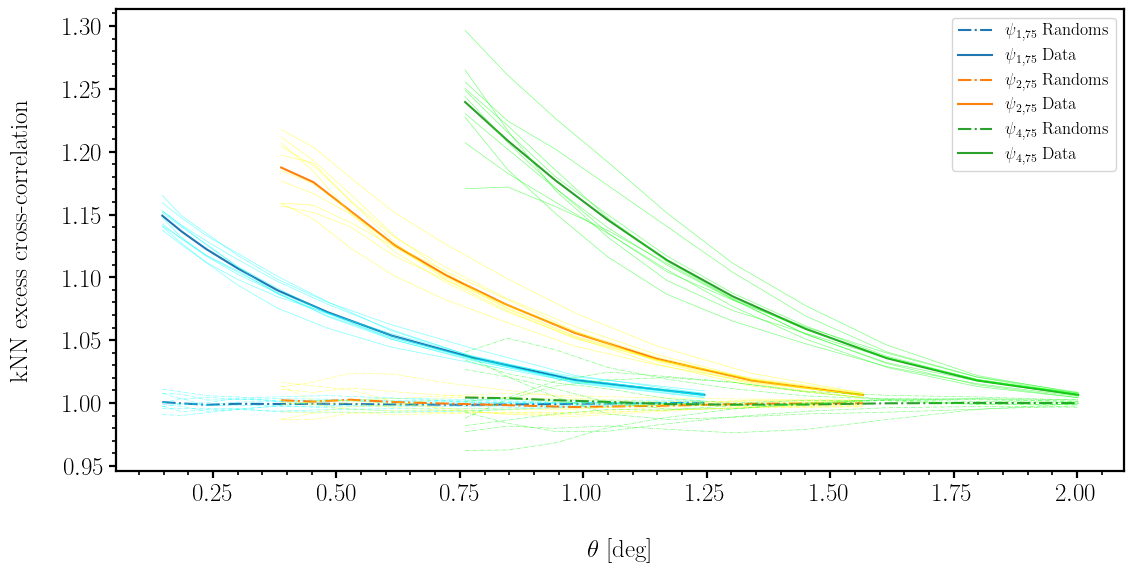

In [69]:
plt.figure(figsize=(13, 6))

for i, k in enumerate(k_List):
    
    plt.plot(np.rad2deg(sel_bins[i]), np.mean(psi[i][:n_reals], axis=0), c=DefaultColorCycle[i], ls='-.', label='$\\psi_{{{:.0f}, {:.0f}}}$ Randoms'.format(k, delta_threshold))
    for realisation in range(n_reals):
        plt.plot(np.rad2deg(sel_bins[i]), psi[i][:n_reals][realisation], c=BrightColors[i], ls='-.', lw=0.5, alpha=0.5, label=None)

    plt.plot(np.rad2deg(sel_bins[i]), np.mean(psi[i][n_reals:], axis=0), c=DefaultColorCycle[i], label='$\\psi_{{{:.0f}, {:.0f}}}$ Data'.format(k, delta_threshold))
    for realisation in range(n_reals):
        plt.plot(np.rad2deg(sel_bins[i]), psi[i][n_reals:][realisation], c=BrightColors[i], lw=0.5, alpha=0.5, label=None)
        
plt.xlabel('\n$\\theta$ [deg]')
plt.ylabel('kNN excess cross-correlation\n')
plt.legend(fontsize=12)
plt.show()
plt.close()

## Tests for Tracer-tracer correlations, unmasked data

### Loading datasets

In [42]:
fol_dataset = '/home/kaustubh/Projects/kNN-Samrajya/Datasets/kNN_2D_Ang'
NSIDE = 256
n_reals = 10
n_tracer = 2_000
sim_num = 49
mask = np.ones(12*NSIDE**2)
mask[mask!=1] = hp.UNSEEN
random_pos_masked_ds_arr = np.load(f'{fol_dataset}/Discrete_tracer_catalog_{n_reals}_realisations_of_{n_tracer}_objects_randomly_sampled_from_the_sky.npy')
cl_pos_masked_ds_arr = np.load(f'{fol_dataset}/Discrete_tracer_catalog_{n_reals}_realisations_of_{n_tracer}_cluster_sized_haloes_projected_from_quijote_high_res_box_realisation_{sim_num}_unmasked.npy')
ga_pos_masked_ds = np.load(f'{fol_dataset}/Discrete_tracer_catalog_single_realisation_of_{n_tracer}_galaxy_sized_haloes_projected_from_quijote_high_res_box_realisation_{sim_num}_unmasked.npy')

### Query mask and query positions

In [43]:
query_mask, query_pos = hf_2DA.create_query_2DA(NSIDE, mask, tolerance=0)

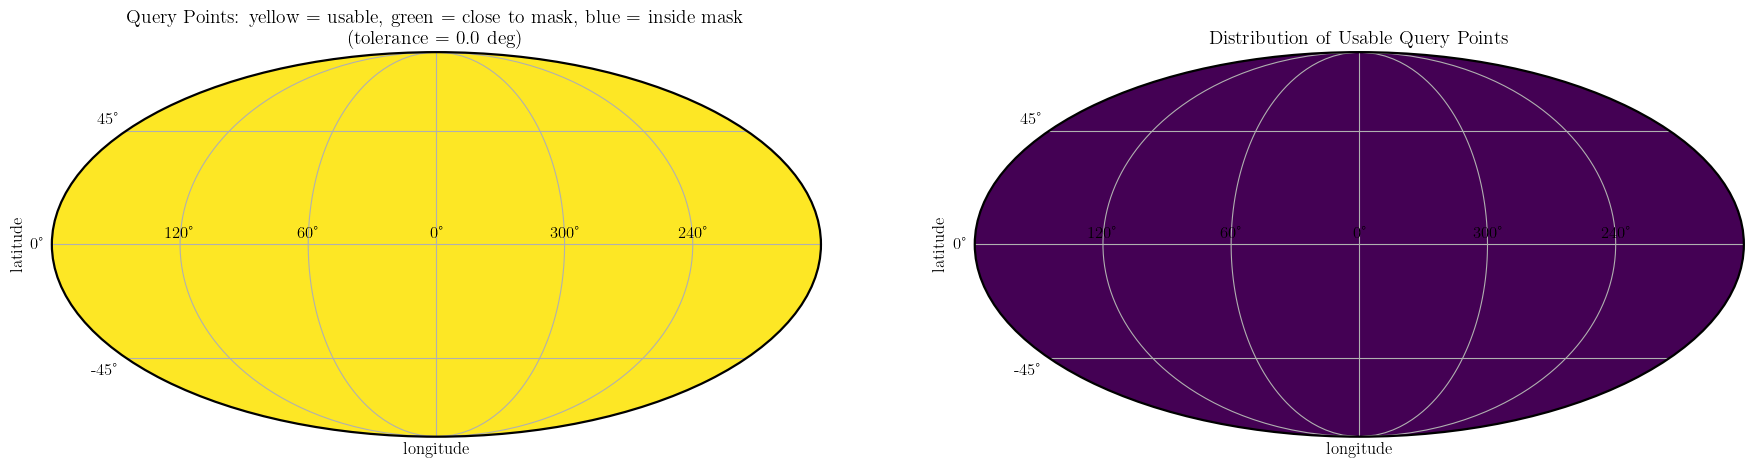

In [11]:
fig = plt.figure(figsize=(18, 7))
ax1, ax2 = plt.subplot(1, 2, 1), plt.subplot(1, 2, 2)

plt.axes(ax1)
projview(
    query_mask,
    coord=["C"],
    graticule=True,
    graticule_labels=True,
    unit="\nPoints/pixel",
    xlabel="longitude",
    ylabel="latitude",
    cbar=False,
    cb_orientation="horizontal",
    latitude_grid_spacing=45,
    projection_type="mollweide",
    title=f"Query Points: yellow = usable, green = close to mask, blue = inside mask \n(tolerance = {np.rad2deg(np.deg2rad(0))} deg)",
    norm="linear", 
    flip="astro",
    min = 0,
    max = 2,
    hold=True,
    sub=121
)

hpx_querymap = cat2hpx(np.rad2deg(query_pos)[:, 1], np.rad2deg(query_pos)[:, 0], nside=NSIDE, radec=False)
plt.axes(ax2)
projview(
    hpx_querymap,
    coord=["C"],
    graticule=True,
    graticule_labels=True,
    unit="\nPoints/pixel",
    xlabel="longitude",
    ylabel="latitude",
    cbar=False,
    cb_orientation="horizontal",
    latitude_grid_spacing=45,
    projection_type="mollweide",
    title="Distribution of Usable Query Points",
    norm="linear", 
    flip="astro",
    hold=True,
    sub=122
)

plt.show()
plt.close()

### Determining the bins

/tmp/ipykernel_23300/2913211282.py:6: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sum+=(mean**i/np.math.factorial(i))*np.exp(-1*mean)


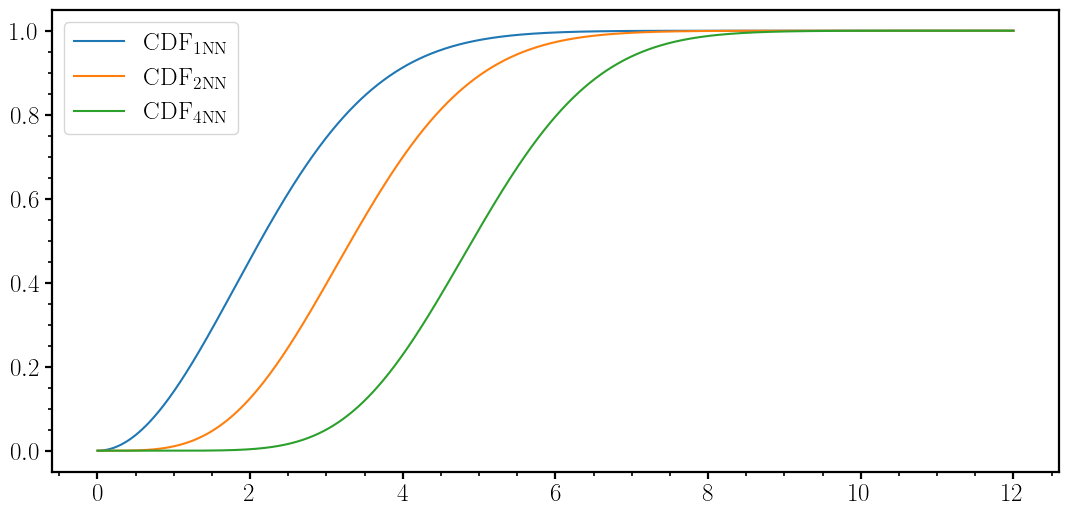

1NN 0.58 4.44
2NN 1.53 5.59
4NN 3.00 7.14

Angular distance bins for 1NN-CDF: 

 [0.55162672 0.69921639 0.88629419 1.12342533 1.42400173 1.80499841
 2.28793209 2.90007638 3.67600203 4.65952931]

Number of bins for 1NN-CDF:  10

Angular distance bins for 2NN-CDF: 

 [1.4515867  1.69522053 1.97974578 2.31202565 2.70007527 3.153255
 3.68249627 4.30056522 5.02237066 5.86532368]

Number of bins for 2NN-CDF:  10

Angular distance bins for 4NN-CDF: 

 [2.84675129 3.17035692 3.53074857 3.93210788 4.37909188 4.87688697
 5.43126912 6.04867089 6.73625607 7.50200278]

Number of bins for 4NN-CDF:  10


In [44]:
kA_kB_List = [(1,1), (2,2), (4,4)]
k_List = [1, 2, 4]
n_bar_red = (cl_pos_masked_ds_arr.shape[1]/(4*np.pi))*(12*NSIDE**2/len(np.where(mask!=hp.UNSEEN)[0]))

bins = np.zeros((len(k_List), 10000))
for i, k in enumerate(k_List):
    bins[i] = np.deg2rad(np.geomspace(0.001, 12, 10000))

Theoretical_Uniform_CDFs_test = []
for i, k in enumerate(k_List):
    Theoretical_Uniform_CDFs_test.append(PoissonUniformCDFs(2*np.pi*(1-np.cos(bins[i])), n_bar_red, k))

plt.figure(figsize=(13,6))
for i, k in enumerate(k_List):
    plt.plot(np.rad2deg(bins[i]), Theoretical_Uniform_CDFs_test[i], label='CDF$_{{\\rm {}NN}}$'.format(k))
plt.legend()
plt.show()
plt.close()

low_bin = np.zeros(len(k_List)).astype(int)
high_bin = np.zeros(len(k_List)).astype(int)
for i, k in enumerate(k_List):
    low_bin[i] = np.searchsorted(Theoretical_Uniform_CDFs_test[i], 0.05)
    high_bin[i] = np.searchsorted(Theoretical_Uniform_CDFs_test[i], 0.95)
    print(f'{k}NN', '{:.2f}'.format(np.rad2deg(bins[i][low_bin[i]])), '{:.2f}'.format(np.rad2deg(bins[i][high_bin[i]])))

sel_bins = np.zeros((len(k_List), 10))
for i, k in enumerate(k_List):
    sel_bins[i] = np.geomspace(bins[i][low_bin[i]]*0.95, bins[i][high_bin[i]]*1.05, 10)

for i, k in enumerate(k_List):
    print(f'\nAngular distance bins for {k}NN-CDF: \n\n', np.rad2deg(sel_bins[i]))
    print(f'\nNumber of bins for {k}NN-CDF: ', len(sel_bins[i]))

BinsRad = sel_bins

### Computing the theoretical CDFs for Poisson data

In [45]:
th_uni_arr = np.zeros((len(k_List), sel_bins.shape[1]))
for i, k in enumerate(k_List):
    th_uni_arr[i] = PoissonUniformCDFs(2*np.pi*(1-np.cos(sel_bins[i])), n_bar_red, k)

# for i, k in enumerate(k_List):
#     plt.plot(np.rad2deg(sel_bins[i]), th_uni_arr[i])

/tmp/ipykernel_23300/2913211282.py:6: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sum+=(mean**i/np.math.factorial(i))*np.exp(-1*mean)


### testing kNN_2D_Ang.TracerTracerCross2DA

In [46]:
randomxgalaxy_kNN_results = kNN_2D_Ang.TracerTracerCross2DA(kA_kB_List, BinsRad, query_pos, random_pos_masked_ds_arr[0], ga_pos_masked_ds, Verbose=True)

Checking inputs ...
	done.

building the trees ...
	first set of tracers done; time taken: 2.02e-03 s.
	second set of tracers done; time taken: 1.70e-03 s.
	combined time: 3.81e-03 s.

computing the tracer NN distances ...
	time taken for tracer A: 9.42e+00 s.
	time taken for tracer B: 9.62e+00 s.
	done

computing the tracer auto-CDFs P_{>=kA}, P_{>=kB} ...
	done; time taken: 5.95e-01 s.

computing the joint-CDFs P_{>=kA, >=kB} ...
	done; time taken: 3.39e-01 s.

total time taken: 2.00e+01 s.


In [47]:
random_autoCDFs = randomxgalaxy_kNN_results[0]
galaxy_autoCDFs = randomxgalaxy_kNN_results[1]
random_jointCDFs = randomxgalaxy_kNN_results[2]

In [48]:
clusterxgalaxy_kNN_results = kNN_2D_Ang.TracerTracerCross2DA(kA_kB_List, BinsRad, query_pos, cl_pos_masked_ds_arr[0], ga_pos_masked_ds, Verbose=True)

Checking inputs ...
	done.

building the trees ...
	first set of tracers done; time taken: 1.79e-03 s.
	second set of tracers done; time taken: 2.59e-03 s.
	combined time: 4.42e-03 s.

computing the tracer NN distances ...
	time taken for tracer A: 9.61e+00 s.
	time taken for tracer B: 8.22e+00 s.
	done

computing the tracer auto-CDFs P_{>=kA}, P_{>=kB} ...
	done; time taken: 6.88e-01 s.

computing the joint-CDFs P_{>=kA, >=kB} ...
	done; time taken: 3.21e-01 s.

total time taken: 1.89e+01 s.


In [49]:
cluster_autoCDFs = clusterxgalaxy_kNN_results[0]
galaxy_autoCDFs = clusterxgalaxy_kNN_results[1]
cluster_jointCDFs = clusterxgalaxy_kNN_results[2]

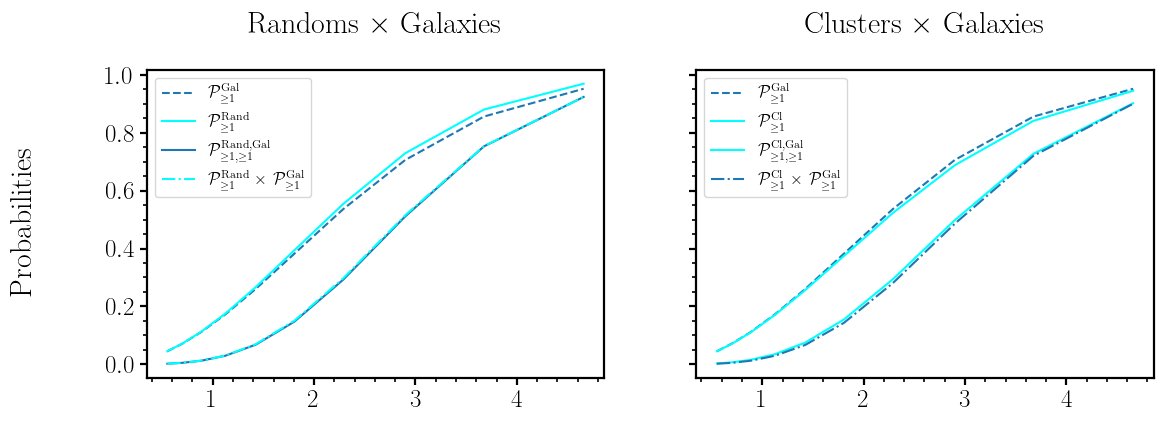

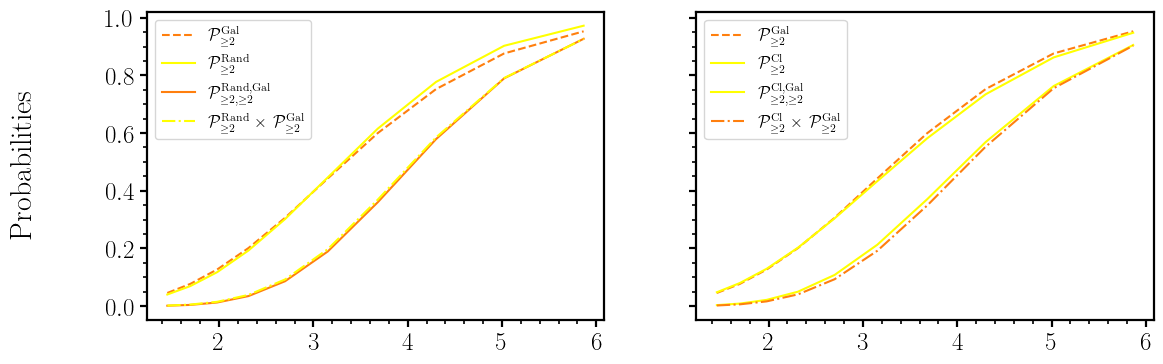

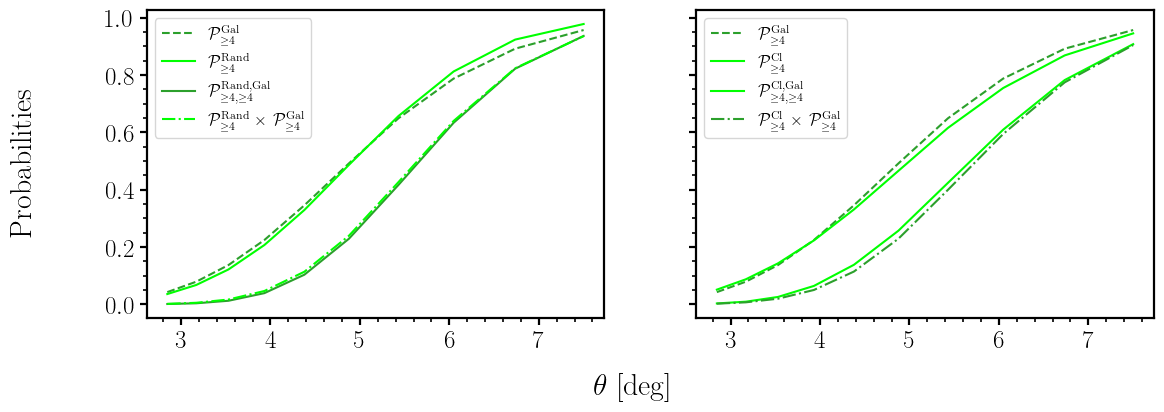

In [50]:
for i, (kA, kB) in enumerate(kA_kB_List):

    fig, (ax, ax1) = plt.subplots(1, 2, figsize=(13, 4), sharey=True)
    
    ax.plot(np.rad2deg(sel_bins[i]), galaxy_autoCDFs[i], c=DefaultColorCycle[i], ls='--', label='$\\mathcal{{P}}^{{\\rm Gal}}_{{\\geq {:.0f}}}$'.format(kB))
    ax.plot(np.rad2deg(sel_bins[i]), random_autoCDFs[i], c=BrightColors[i], label='$\\mathcal{{P}}^{{\\rm Rand}}_{{\\geq {:.0f}}}$'.format(kA))
    ax.plot(np.rad2deg(sel_bins[i]), random_jointCDFs[i], c=DefaultColorCycle[i], label='$\\mathcal{{P}}^{{\\rm Rand, Gal}}_{{\\geq {:.0f}, \\geq {:.0f}}}$'.format(kA, kB))
    ax.plot(np.rad2deg(sel_bins[i]), random_autoCDFs[i]*galaxy_autoCDFs[i], c=BrightColors[i], ls='-.', label='$\\mathcal{{P}}^{{\\rm Rand}}_{{\\geq {:.0f}}}$ $\\times$ $\\mathcal{{P}}^{{\\rm Gal}}_{{\\geq {:.0f}}}$'.format(kA, kB))
    ax.legend(fontsize=12)
    if i==0: ax.set_title('Randoms $\\times$ Galaxies\n')
    
    ax1.plot(np.rad2deg(sel_bins[i]), galaxy_autoCDFs[i], c=DefaultColorCycle[i], ls='--', label='$\\mathcal{{P}}^{{\\rm Gal}}_{{\\geq {:.0f}}}$'.format(kB))
    ax1.plot(np.rad2deg(sel_bins[i]), cluster_autoCDFs[i], c=BrightColors[i], label='$\\mathcal{{P}}^{{\\rm Cl}}_{{\\geq {:.0f}}}$'.format(kA))
    ax1.plot(np.rad2deg(sel_bins[i]), cluster_jointCDFs[i], c=BrightColors[i], label='$\\mathcal{{P}}^{{\\rm Cl, Gal}}_{{\\geq {:.0f}, \\geq {:.0f}}}$'.format(kA, kB))
    ax1.plot(np.rad2deg(sel_bins[i]), cluster_autoCDFs[i]*galaxy_autoCDFs[i], c=DefaultColorCycle[i], ls='-.', label='$\\mathcal{{P}}^{{\\rm Cl}}_{{\\geq {:.0f}}}$ $\\times$ $\\mathcal{{P}}^{{\\rm Gal}}_{{\\geq {:.0f}}}$'.format(kA, kB))
    ax1.legend(fontsize=12)
    if i==0: ax1.set_title('Clusters $\\times$ Galaxies\n')
    if i==len(k_List)-1: fig.supxlabel(r'$\theta$ [deg]', y=-0.1)
    fig.supylabel('Probabilities')
    
    plt.show()
    plt.close()

In [51]:
randoms_psi = hf.kNN_excess_cross_corr(random_autoCDFs, galaxy_autoCDFs, random_jointCDFs, k1_k2_list=kA_kB_List)
cluster_psi = hf.kNN_excess_cross_corr(cluster_autoCDFs, galaxy_autoCDFs, cluster_jointCDFs, k1_k2_list=kA_kB_List)

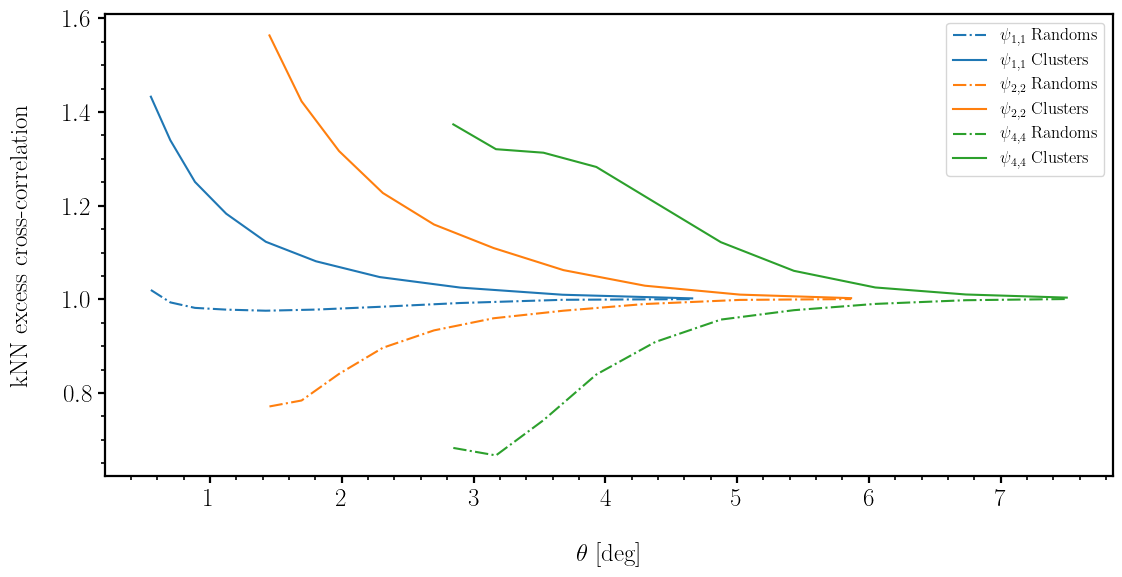

In [52]:
plt.figure(figsize=(13, 6))

for i, (kA, kB) in enumerate(kA_kB_List):
    plt.plot(np.rad2deg(sel_bins[i]), randoms_psi[i], c=DefaultColorCycle[i], ls='-.', label='$\\psi_{{{:.0f}, {:.0f}}}$ Randoms'.format(kA, kB))
    plt.plot(np.rad2deg(sel_bins[i]), cluster_psi[i], c=DefaultColorCycle[i], label='$\\psi_{{{:.0f}, {:.0f}}}$ Clusters'.format(kA, kB))
        
plt.xlabel('\n$\\theta$ [deg]')
plt.ylabel('kNN excess cross-correlation\n')
plt.legend(fontsize=12)
plt.show()
plt.close()

### testing kNN_2D_Ang.TracerFieldCross2DA_DataVector

In [53]:
combined_pos_masked_ds_arr = np.concatenate([random_pos_masked_ds_arr, cl_pos_masked_ds_arr], axis=0)

In [54]:
random_pos_masked_ds_arr.shape, cl_pos_masked_ds_arr.shape, combined_pos_masked_ds_arr.shape

((10, 2000, 2), (10, 2000, 2), (20, 2000, 2))

In [55]:
clusterxgalaxy_kNN_results_DataVector = kNN_2D_Ang.TracerTracerCross2DA_DataVector(kA_kB_List, BinsRad, query_pos, combined_pos_masked_ds_arr, ga_pos_masked_ds, Verbose=True)

Checking inputs ...
	done.


First carrying out nearest-neighbour computations for tracer B


building the tree...
	time taken: 1.63e-03 s.

computing the NN distances...
	done; time taken: 8.16e+00 s.

computing the auto-CDFs P_{>=kB} ...
	done; time taken: 3.00e-01 s.


Now looping over the realisations of tracer A



--------------  Realisation 1/20  --------------


building the trees ...
	done; time taken: 1.20e-03 s.

computing the NN distances ...
	done; time taken: 8.75e+00 s.

computing the auto-CDFs P_{>=kA} ...
	done; time taken: 3.96e-01 s.

computing the joint-CDFs P_{>=kA, >=kB} ...
	done; time taken: 3.88e-01 s.

time taken for realisation 1: 9.53e+00 s.


--------------  Realisation 2/20  --------------


building the trees ...
	done; time taken: 1.29e-03 s.

computing the NN distances ...
	done; time taken: 8.16e+00 s.

computing the auto-CDFs P_{>=kA} ...
	done; time taken: 3.38e-01 s.

computing the joint-CDFs P_{>=kA, >=kB} ...
	done; time taken: 3.38e-01 s.

time t

In [56]:
autoCDFs = clusterxgalaxy_kNN_results_DataVector[0]
galAutoCDFs = clusterxgalaxy_kNN_results_DataVector[1]
jointCDFs = clusterxgalaxy_kNN_results_DataVector[2]

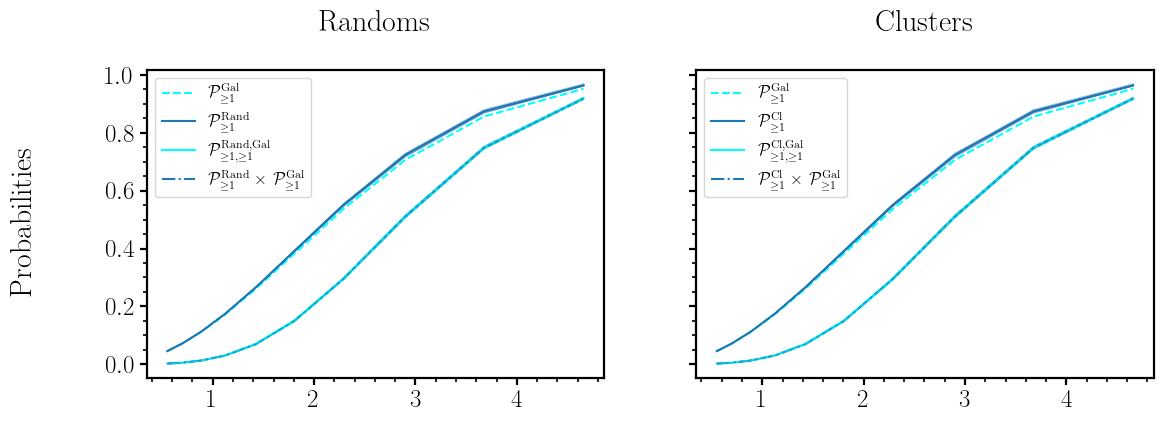

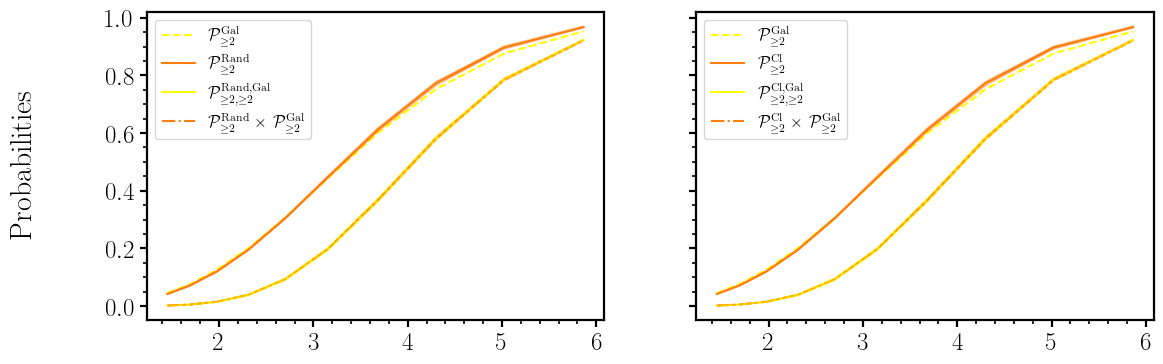

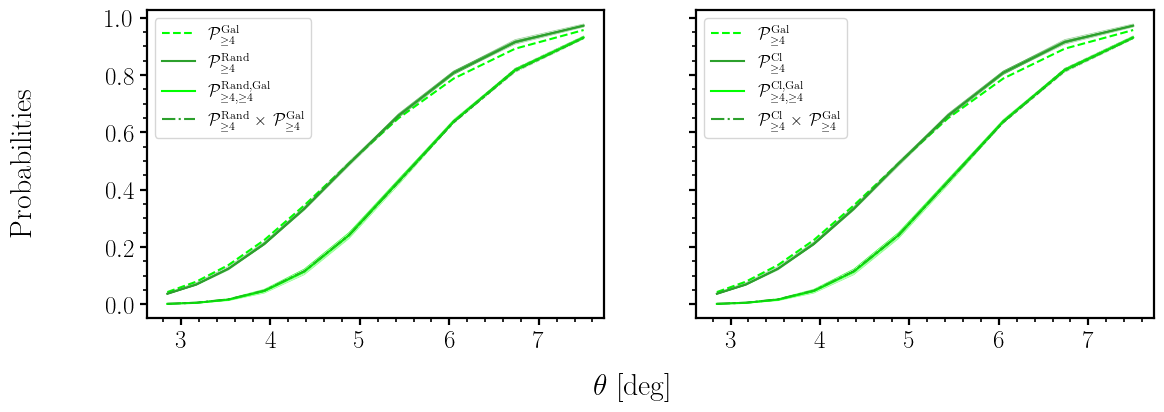

In [57]:
for i, (kA, kB) in enumerate(kA_kB_List):

    fig, (ax, ax1) = plt.subplots(1, 2, figsize=(13, 4), sharey=True)
    
    ax.plot(np.rad2deg(sel_bins[i]), galAutoCDFs[i], c=BrightColors[i], ls='dashed', label='$\\mathcal{{P}}^{{\\rm Gal}}_{{\\geq {:.0f}}}$'.format(kB))
    ax.plot(np.rad2deg(sel_bins[i]), np.mean(autoCDFs[i][:n_reals], axis=0), c=DefaultColorCycle[i], label='$\\mathcal{{P}}^{{\\rm Rand}}_{{\\geq {:.0f}}}$'.format(kA))
    ax.plot(np.rad2deg(sel_bins[i]), np.mean(jointCDFs[i][:n_reals], axis=0), c=BrightColors[i], label='$\\mathcal{{P}}^{{\\rm Rand, Gal}}_{{\\geq {:.0f}, \\geq {:.0f}}}$'.format(kA, kB))
    ax.plot(np.rad2deg(sel_bins[i]), np.mean(autoCDFs[i][:n_reals], axis=0)*galAutoCDFs[i], c=DefaultColorCycle[i], ls='-.', label='$\\mathcal{{P}}^{{\\rm Rand}}_{{\\geq {:.0f}}}$ $\\times$ $\\mathcal{{P}}^{{\\rm Gal}}_{{\\geq {:.0f}}}$'.format(kA, kB))
    for realisation in range(n_reals):
        ax.plot(np.rad2deg(sel_bins[i]), autoCDFs[i][:n_reals][realisation], c=DefaultColorCycle[i], lw=0.5, alpha=0.5, label=None)
        ax.plot(np.rad2deg(sel_bins[i]), jointCDFs[i][:n_reals][realisation], c=BrightColors[i], lw=0.5, alpha=0.5, label=None)
        ax.plot(np.rad2deg(sel_bins[i]), autoCDFs[i][:n_reals][realisation]*galAutoCDFs[i], lw=0.5, alpha=0.5, c=DefaultColorCycle[i], ls='-.', label=None)
    ax.legend(fontsize=12)
    if i==0: ax.set_title('Randoms\n')
    
    ax1.plot(np.rad2deg(sel_bins[i]), galAutoCDFs[i], c=BrightColors[i], ls='dashed', label='$\\mathcal{{P}}^{{\\rm Gal}}_{{\\geq {:.0f}}}$'.format(kB))
    ax1.plot(np.rad2deg(sel_bins[i]), np.mean(autoCDFs[i][:n_reals], axis=0), c=DefaultColorCycle[i], label='$\\mathcal{{P}}^{{\\rm Cl}}_{{\\geq {:.0f}}}$'.format(kA))
    ax1.plot(np.rad2deg(sel_bins[i]), np.mean(jointCDFs[i][:n_reals], axis=0), c=BrightColors[i], label='$\\mathcal{{P}}^{{\\rm Cl, Gal}}_{{\\geq {:.0f}, \\geq {:.0f}}}$'.format(kA, kB))
    ax1.plot(np.rad2deg(sel_bins[i]), np.mean(autoCDFs[i][:n_reals], axis=0)*galAutoCDFs[i], c=DefaultColorCycle[i], ls='-.', label='$\\mathcal{{P}}^{{\\rm Cl}}_{{\\geq {:.0f}}}$ $\\times$ $\\mathcal{{P}}^{{\\rm Gal}}_{{\\geq {:.0f}}}$'.format(kA, kB))
    for realisation in range(n_reals):
        ax1.plot(np.rad2deg(sel_bins[i]), autoCDFs[i][:n_reals][realisation], c=DefaultColorCycle[i], lw=0.5, alpha=0.5, label=None)
        ax1.plot(np.rad2deg(sel_bins[i]), jointCDFs[i][:n_reals][realisation], c=BrightColors[i], lw=0.5, alpha=0.5, label=None)
        ax1.plot(np.rad2deg(sel_bins[i]), autoCDFs[i][:n_reals][realisation]*galAutoCDFs[i], lw=0.5, alpha=0.5, c=DefaultColorCycle[i], ls='-.', label=None)
    ax1.legend(fontsize=12)
    if i==0: ax1.set_title('Clusters\n')

    if i==len(kA_kB_List)-1: fig.supxlabel(r'$\theta$ [deg]', y=-0.1)
    fig.supylabel('Probabilities')
    
    plt.show()
    plt.close()

In [58]:
psi = hf.kNN_excess_cross_corr(autoCDFs, galAutoCDFs, jointCDFs, k1_k2_list=kA_kB_List)

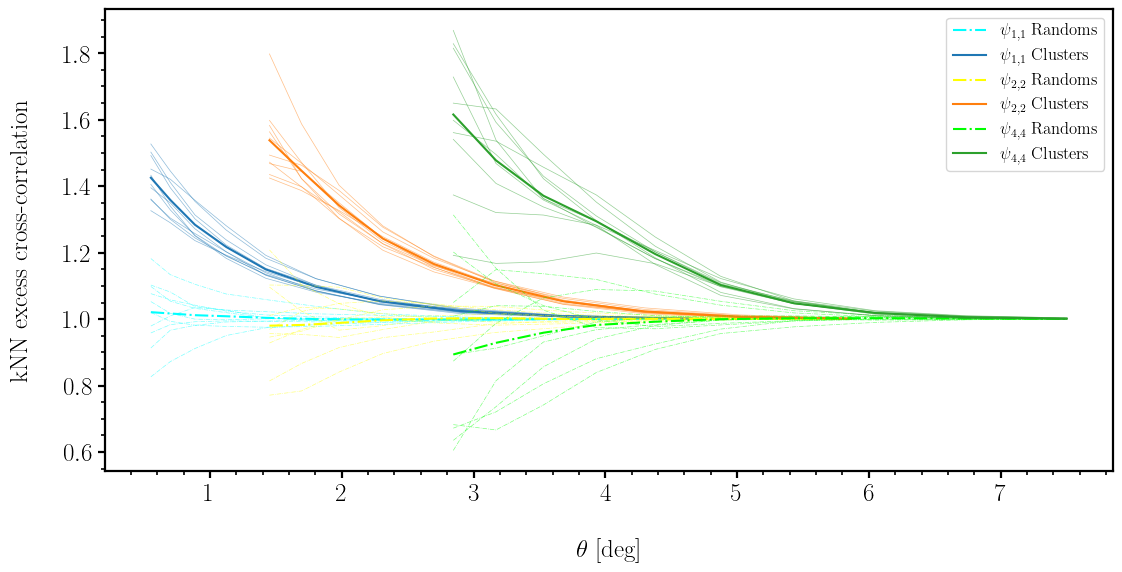

In [61]:
plt.figure(figsize=(13, 6))

for i, (kA, kB) in enumerate(kA_kB_List):
    
    plt.plot(np.rad2deg(sel_bins[i]), np.mean(psi[i][:n_reals], axis=0), c=BrightColors[i], ls='-.', label='$\\psi_{{{:.0f}, {:.0f}}}$ Randoms'.format(kA, kB))
    for realisation in range(n_reals):
        plt.plot(np.rad2deg(sel_bins[i]), psi[i][:n_reals][realisation], c=BrightColors[i], ls='-.', lw=0.5, alpha=0.5, label=None)

    plt.plot(np.rad2deg(sel_bins[i]), np.mean(psi[i][n_reals:], axis=0), c=DefaultColorCycle[i], label='$\\psi_{{{:.0f}, {:.0f}}}$ Clusters'.format(kA, kB))
    for realisation in range(n_reals):
        plt.plot(np.rad2deg(sel_bins[i]), psi[i][n_reals:][realisation], c=DefaultColorCycle[i], lw=0.5, alpha=0.5, label=None)
        
plt.xlabel('\n$\\theta$ [deg]')
plt.ylabel('kNN excess cross-correlation\n')
plt.legend(fontsize=12)
plt.show()
plt.close()